# Ransomware Communication Analysis: Linguistic Patterns & Financial Tiers
**FYP Data Analysis PHASE 1 Work**

## Overview
For PHASE 1 of our paper and to establish some ground work, this notebook processes text data from ransomware ransom notes to analyze linguistic patterns—specifically "Service" (helpfulness) and "Aggression" (threats). It correlates these lexical density scores with external financial data (estimated ransom demands) to identify strategic differences between elite (Tier 1) and amateur (Tier 3) cybercriminal groups.

## Methodology
1. **Ingestion**: Reads raw `.txt` ransom notes and loads financial statistics from `.csv`.
2. **Lexical Analysis**: Calculates density scores based on predefined keyword dictionaries.
3. **Data Aggregation**: Groups data by ransomware family and merges with financial tiers.
4. **Visualization**: Generates three key charts to illustrate market positioning and professionalism gaps.

In [30]:
# --- 1. CONFIGURATION & SETUP ---
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style for the charts
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Paths
NOTES_FOLDER = 'ransom_notes_dataset/'  # Folder containing your .txt files
STATS_FILE = 'ransom_stats.csv'         # File containing the financial data


In [31]:
# --- 2. DEFINITIONS ---

# A. Keyword Dictionaries for Scoring
service_keywords = [
    'guarantee', 'support', 'help', 'decrypt', 'customer', 'service', 
    'reputation', 'honest', 'assist', 'chat', 'ticket', 'free', 'trial', 
    'post-paid', 'welcome', 'team', 'contact', 'please'
]

aggression_keywords = [
    'destroy', 'leak', 'publish', 'media', 'fail', 'fatal', 'useless', 
    'regret', 'warn', 'attack', 'delete', 'lost', 'forever', 'shame',
    'criminal', 'police', 'never', 'negotiators'
]

# B. Mapping Dictionary
group_mapping = {
    # TIER 1 (Elite)
    'lockbit': ['lockbit'],
    'darkangels': ['darkangels'],
    'alphv': ['alphv', 'blackcat'],
    'ransomhub': ['ransomhub'],
    'clop': ['clop'],
    'revil': ['revil', 'sodinokibi'],
    'conti': ['conti'],
    'blackmatter': ['blackmatter'],
    'qilin': ['qilin'],
    'maze': ['maze'], 
    'darkside': ['darkside'],
    'embargo': ['embargo'],
    'blackbasta': ['blackbasta'],
    'royal': ['royal'],
    'monti': ['monti'],
    'hive': ['hive'],
    'inc': ['inc'],
    'ryuk': ['ryuk'],
    'cuba': ['cuba'],
    'pysa': ['pysa'],
    'ragnarlocker': ['ragnarlocker'],
    'babuk': ['babuk'],
    'karakurt': ['karakurt'],
    'egregor': ['egregor'],
    'ransomhouse': ['ransomhouse'],
    'suncrypt': ['suncrypt'],
    'megacortex': ['megacortex'],
    'karakurt': ['karakurt'],

    # TIER 2 (Mid-Market)
    'nokoyawa': ['nokoyawa'],
    'medusa': ['medusa'],
    'rhysida': ['rhysida'],
    'cactus': ['cactus'],
    'doppelpaymer': ['doppelpaymer'],
    'lorenz': ['lorenz'],
    'avaddon': ['avaddon'],
    'bianlian': ['bianlian'],
    'blackbyte': ['blackbyte'],
    'play': ['play'],
    'akira': ['akira'],
    '8base': ['8base'],
    'fog': ['fog'],
    'trigona': ['trigona'],
    'netwalker': ['netwalker'],
    'knight': ['knight'],
    'vicesociety': ['vicesociety'],
    'samsam': ['samsam'],
    'avoslocker': ['avoslocker'],
    'stormous': ['stormous'],
    'robinhood': ['robinhood'],         
    'nephilim': ['nephilim'],
    'bitpaymer': ['bitpaymer'],
    'satan': ['satan'],
    'jaff': ['jaff'],

    # TIER 3 (Amateur/Mass Market)
    'snatch': ['snatch'],
    'makop': ['makop'],
    'phobos': ['phobos'],
    'dharma': ['dharma'],
    'gandcrab': ['gandcrab'],
    'nemty': ['nemty'],
    'cerber': ['cerber'],
    'globeimposter': ['globeimposter'],
    'magniber': ['magniber'],
    'locky': ['locky'],
    'stop': ['stop'],
    'qlocker': ['qlocker'],
    'teslacrypt': ['teslacrypt'],
    'wannacry': ['wannacry', 'wcry'],
    'xorist': ['xorist'],
    'matrix': ['matrix'],
    'torrentlocker': ['torrentlocker'],
    'cryptolocker': ['cryptolocker'],
    'cryptowall': ['cryptowall'],
    'jigsaw': ['jigsaw'],
    'satana': ['satana'],
    'ctblocker': ['ctblocker'],
    'spora': ['spora'],
    'badrabbit': ['badrabbit'],
    'shade': ['shade'],
    'petya': ['petya'],
    'keranger': ['keranger'],
    'mamba': ['mamba'],
}


In [32]:
# --- 3. FUNCTIONS ---

def analyze_note(text):
    """
    Calculates Service and Aggression scores using Lexical Density.
    Returns normalized score per 100 words.
    """
    text_lower = text.lower()
    
    # 1. Count Keywords
    service_count = sum(text_lower.count(word) for word in service_keywords)
    aggression_count = sum(text_lower.count(word) for word in aggression_keywords)
    
    # 2. Normalize Scores (Score per 100 words)
    word_count = len(text_lower.split())
    if word_count == 0: return 0, 0
    
    # Multiply by 100 for readability (e.g., Score of 5.2 instead of 0.052)
    service_score = (service_count / word_count) * 100
    aggression_score = (aggression_count / word_count) * 100
    
    return service_score, aggression_score


In [34]:
# --- 4. DATA PROCESSING ---


print("Processing files...")
raw_data = []


# Loop through files
if not os.path.exists(NOTES_FOLDER):
    print(f"ERROR: Folder '{NOTES_FOLDER}' not found. Please create it.")
else:
    for filename in os.listdir(NOTES_FOLDER):
        if filename.endswith(".txt"):
            
            # Identify Group - Enhanced for exact matching
            identified_group = None
            filename_lower = filename.lower().replace('.txt', '')  # Remove extension for cleaner matching
            
            # STEP 1: Try exact match first (prevents 'satan' matching 'satana')
            for csv_name, search_terms in group_mapping.items():
                if filename_lower in search_terms:
                    identified_group = csv_name
                    break
            
            # STEP 2: If no exact match, try substring matching (for files like 'alphv_v2.txt')
            if not identified_group:
                filename_lower_with_ext = filename.lower()  # Restore for substring check
                for csv_name, search_terms in group_mapping.items():
                    if any(term in filename_lower_with_ext for term in search_terms):
                        identified_group = csv_name
                        break
            
            if not identified_group:
                continue # Skip unknown files
                
            # Read and Analyze
            try:
                with open(os.path.join(NOTES_FOLDER, filename), 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                    s_score, a_score = analyze_note(content)
                    
                    raw_data.append({
                        'Group': identified_group,
                        'Service_Score': s_score,
                        'Aggression_Score': a_score
                    })
            except Exception as e:
                print(f"Could not read {filename}: {e}")


# Create DataFrame and Aggregate
df_notes = pd.DataFrame(raw_data)


if df_notes.empty:
    print("WARNING: No data found. Check your folder name and file names.")
else:
    # Group by name and calculate average (handles multiple files per group)
    df_final = df_notes.groupby('Group').mean(numeric_only=True).reset_index()
    
    # Merge with Financial Data
    if os.path.exists(STATS_FILE):
        df_finance = pd.read_csv(STATS_FILE)


        # Ensure column names match exactly
        df_merged = pd.merge(df_final, df_finance, on='Group', how='inner')
        print(f"Successfully processed {len(df_merged)} groups.")
        
        # Display sample data
        display(df_merged.head())
    else:
        print(f"ERROR: '{STATS_FILE}' not found. Cannot merge financial data.")
        df_merged = df_final # Fallback for debugging


Processing files...
Successfully processed 80 groups.


,Group,Service_Score,Aggression_Score,Tier,Typical_Demand_USD,Metric_Type
0,8base,3.567087,2.791633,2,250000,tier_based_proxy
1,akira,1.739221,0.627983,2,1000000,documented_typical_or_range
2,alphv,0.690365,0.847845,1,22000000,largest_known_demand
3,avaddon,1.289106,0.859404,2,600000,documented_typical_or_range
4,avoslocker,1.796407,1.197605,2,75000,documented_typical_or_range


## 5. Visualizations

The following charts illustrate the correlation between linguistic strategies and financial demands.
1. **The Professionalism Gap**: Comparing Service Density across tiers.
2. **Market Positioning**: Service Density vs. Demand Size.
3. **Strategy Matrix**: Aggression vs. Service Density.


Where per‑group average ransom data was unavailable, we used either the midpoint of a documented typical demand range, the largest known demand, or a tier‑based proxy, as indicated by the Metric_Type column. These values are used only for visualization and not interpreted as precise statistical averages.

/var/folders/2t/sql_165s2hd2qxb97wbst3gh0000gn/T/ipykernel_68582/3931525451.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_merged, x='Tier', y='Service_Score', palette=custom_palette, errorbar=None)


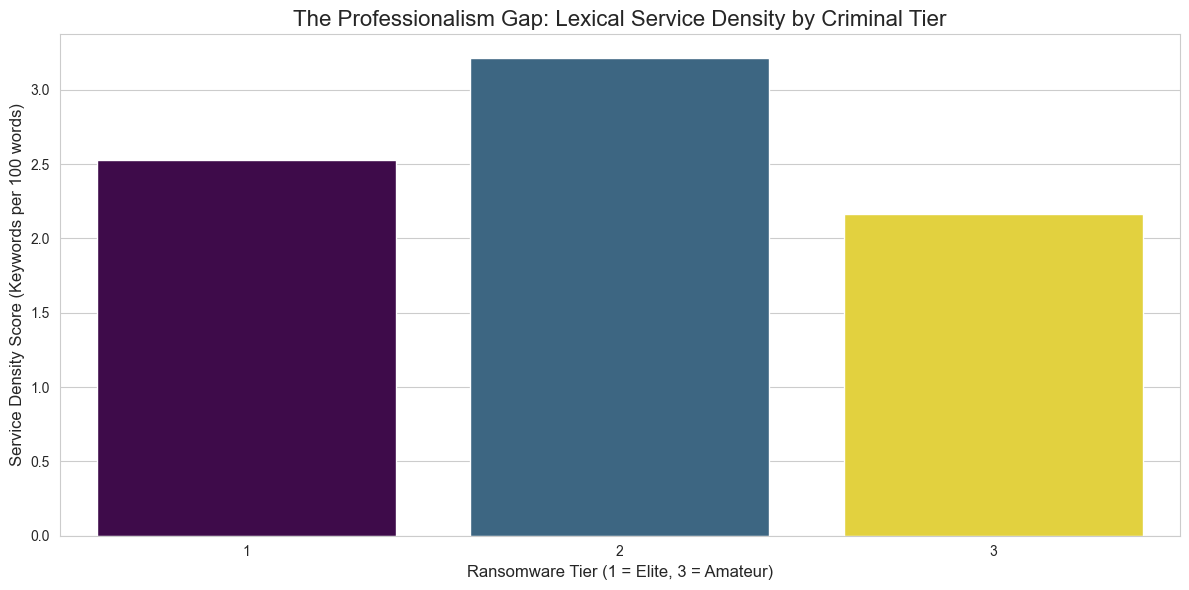

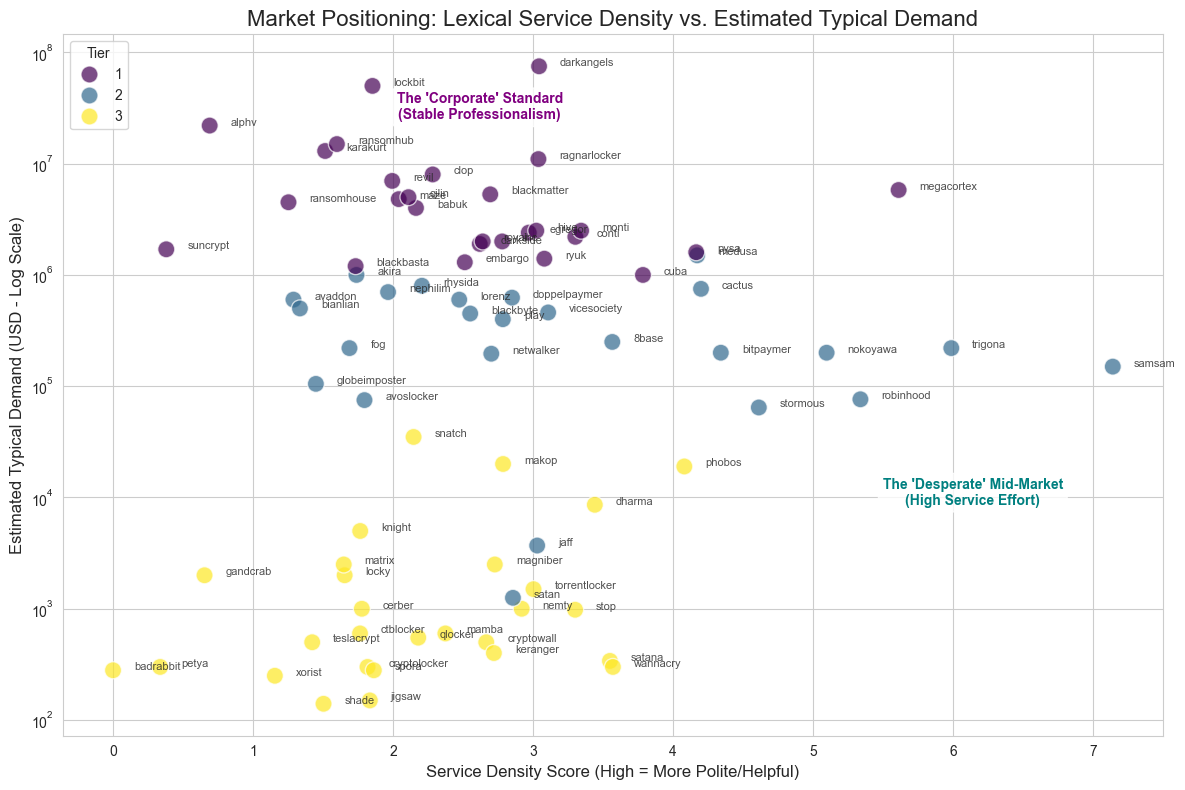

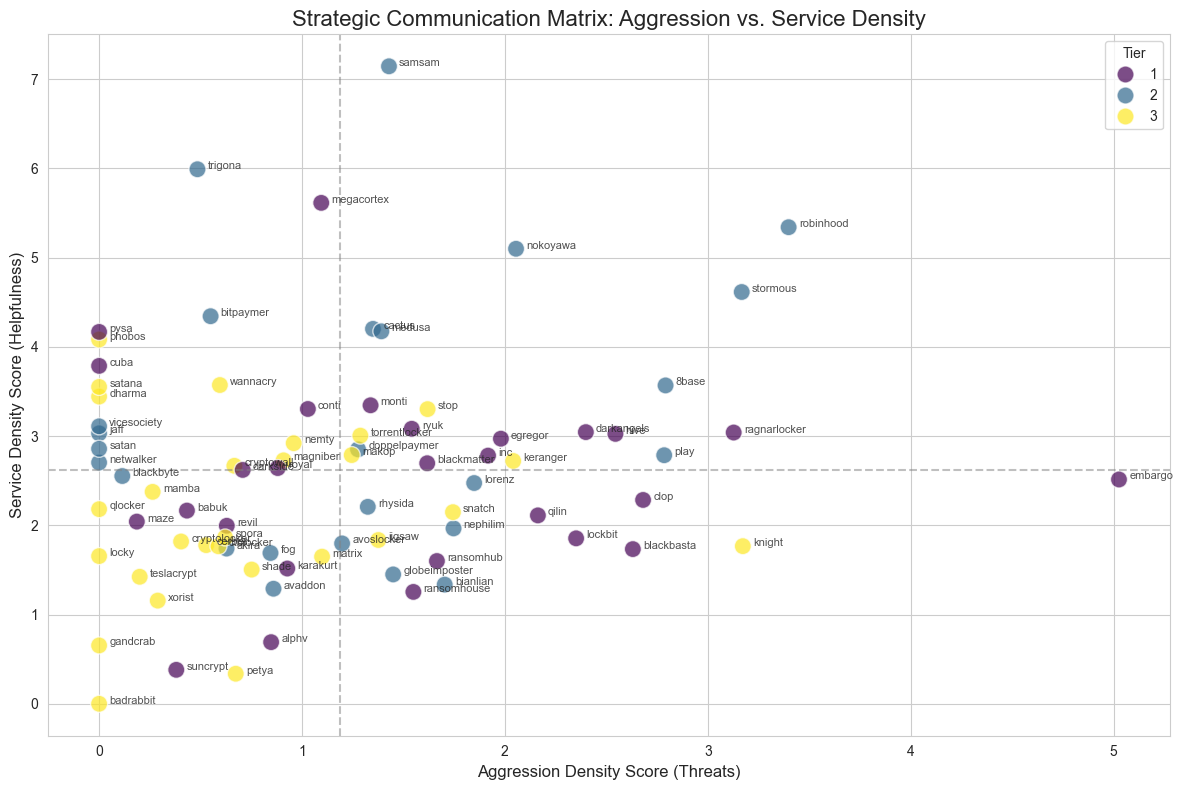

In [35]:
# --- CHART 1: The "Professionalism Gap" (Bar Chart) ---
plt.figure(figsize=(12, 6))
custom_palette = {'1': '#440154', '2': '#31688e', '3': '#fde724'}
sns.barplot(data=df_merged, x='Tier', y='Service_Score', palette=custom_palette, errorbar=None)
plt.title('The Professionalism Gap: Lexical Service Density by Criminal Tier', fontsize=16)
plt.xlabel('Ransomware Tier (1 = Elite, 3 = Amateur)', fontsize=12)
plt.ylabel('Service Density Score (Keywords per 100 words)', fontsize=12)
plt.tight_layout()
plt.show()


# --- CHART 2: The "Signal Effectiveness" (Scatter Plot) ---
plt.figure(figsize=(12, 8))

scatter = sns.scatterplot(
    data=df_merged, 
    x='Service_Score', 
    y='Typical_Demand_USD', 
    hue='Tier',
    s=150,
    palette=['#440154', '#31688e', '#fde724'],
    alpha=0.7,
    legend='full'
)

# Zone annotations
plt.text(df_merged['Service_Score'].max() - 1.0, 
         df_merged[df_merged['Tier'] > 1]['Typical_Demand_USD'].median(),
         "The 'Desperate' Mid-Market\n(High Service Effort)", 
         fontsize=10, color='teal', ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.text(df_merged[df_merged['Tier'] == 1]['Service_Score'].median(), 
         df_merged['Typical_Demand_USD'].max() / 3.0,
         "The 'Corporate' Standard\n(Stable Professionalism)", 
         fontsize=10, color='purple', ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Label all groups
for idx in df_merged.index:
    plt.text(
        df_merged.loc[idx, 'Service_Score'] + 0.15, 
        df_merged.loc[idx, 'Typical_Demand_USD'], 
        df_merged.loc[idx, 'Group'], 
        fontsize=8,
        alpha=0.8
    )

plt.yscale('log')
plt.title('Market Positioning: Lexical Service Density vs. Estimated Typical Demand', fontsize=16)
plt.xlabel('Service Density Score (High = More Polite/Helpful)', fontsize=12)
plt.ylabel('Estimated Typical Demand (USD - Log Scale)', fontsize=12)

# FIXED: Remove custom legend labels, let seaborn handle it automatically
plt.legend(title='Tier', loc='upper left')

plt.tight_layout()
plt.show()


# --- CHART 3: The "Strategy Matrix" (Aggression vs Service) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_merged, 
    x='Aggression_Score', 
    y='Service_Score', 
    hue='Tier', 
    palette=['#440154', '#31688e', '#fde724'],
    s=150,
    alpha=0.7,
    legend='full'
)

# ADDED BACK: Label all groups
for idx in df_merged.index:
    plt.text(
        df_merged.loc[idx, 'Aggression_Score'] + 0.05, 
        df_merged.loc[idx, 'Service_Score'], 
        df_merged.loc[idx, 'Group'], 
        fontsize=8,
        alpha=0.8
    )
    
plt.axhline(y=df_merged['Service_Score'].mean(), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=df_merged['Aggression_Score'].mean(), color='gray', linestyle='--', alpha=0.5)
plt.title('Strategic Communication Matrix: Aggression vs. Service Density', fontsize=16)
plt.xlabel('Aggression Density Score (Threats)', fontsize=12)
plt.ylabel('Service Density Score (Helpfulness)', fontsize=12)

# FIXED: Let seaborn handle legend automatically
plt.legend(title='Tier', loc='upper right')

plt.tight_layout()
plt.show()


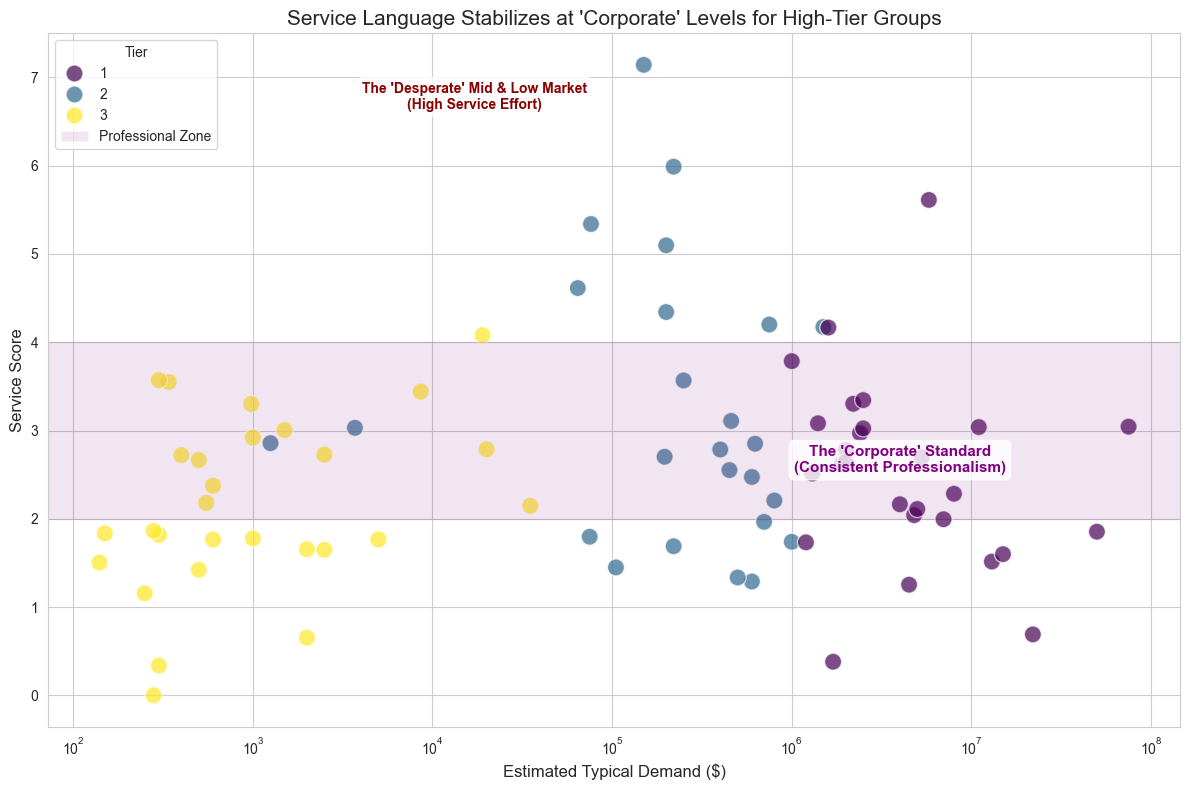


Final Data Table (Sorted by Service Score):


,Group,Tier,Service_Score,Typical_Demand_USD
65,samsam,2,7.142857,150000
76,trigona,2,5.989284,220000
45,megacortex,1,5.612696,5800000
62,robinhood,2,5.339806,76280
50,nokoyawa,2,5.098217,200000
...,...,...,...,...
2,alphv,1,0.690365,22000000
27,gandcrab,3,0.653595,2000
73,suncrypt,1,0.380469,1700000
51,petya,3,0.336700,300


In [36]:
# --- FINAL NARRATIVE CHART: Stabilization of Service Language ---
plt.figure(figsize=(12, 8))

sns.scatterplot(data=df_merged, x='Typical_Demand_USD', y='Service_Score', 
                hue='Tier', s=150, 
                palette=['#440154', '#31688e', '#fde724'],
                alpha=0.7,
                legend='full')
plt.xscale('log')

plt.text(df_merged[df_merged['Tier'] > 1]['Typical_Demand_USD'].median() * 2,
         df_merged[df_merged['Service_Score'] > 4]['Service_Score'].max() - 0.5,
         "The 'Desperate' Mid & Low Market\n(High Service Effort)", 
         fontsize=10, color='darkred', ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.text(df_merged[df_merged['Tier'] == 1]['Typical_Demand_USD'].median(),
         df_merged[df_merged['Tier'] == 1]['Service_Score'].mean(),
         "The 'Corporate' Standard\n(Consistent Professionalism)", 
         fontsize=11, color='purple', ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

zone_patch = plt.axhspan(2, 4, color='purple', alpha=0.1)

from matplotlib.patches import Patch
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(Patch(facecolor='purple', alpha=0.1, label='Professional Zone'))

# FIXED: Use actual tier values from legend, not custom labels
plt.legend(handles=handles, labels=labels + ['Professional Zone'], 
           title='Tier', loc='upper left')

plt.title("Service Language Stabilizes at 'Corporate' Levels for High-Tier Groups", fontsize=15)
plt.xlabel("Estimated Typical Demand ($)", fontsize=12)
plt.ylabel("Service Score", fontsize=12)
plt.tight_layout()
plt.show()

print("\nFinal Data Table (Sorted by Service Score):")
display(df_merged[['Group', 'Tier', 'Service_Score', 'Typical_Demand_USD']].sort_values(by='Service_Score', ascending=False))
